# Minimal Spanning Tree - painter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from scipy import signal

In [2]:
def sample_points(xy, z, n=1):
    p = np.max(z)-z
    p = p/np.sum(p)
    out = xy[np.random.choice(list(range(xy.shape[0])), p=p, size=n),:]
    if n==1:
        out = out[0]
    #print(out)
    return out
    
#sample_points(imgxy, imgz, n=1)

In [3]:
class PQ:
    """Priority queue"""
    def __init__(self):
        self.x = [None]
        
    def add(self, key, val):
        self.x.append((key,val))
        self._swim(len(self.x)-1)
        
    def n(self):
        return len(self.x)-1
        
    def pop(self):
        if len(self.x)==1: return None
        out = self.x[1]
        self.x[1] = self.x[-1]
        self.x.pop(-1)
        self._sink(1)
        return out[1]
    
    def _swap(self,i,j):
        self.x[i],self.x[j] = self.x[j],self.x[i]
    
    def _swim(self, i):
        if i==1: return
        if self.x[i//2]>self.x[i]:
            self._swap(i//2, i)
            self._swim(i//2)
            
    def _sink(self, i):
        if i*2 < len(self.x) and self.x[i]>self.x[2*i]:
            self._swap(i, 2*i)
            self._sink(2*i)
        if i*2+1 < len(self.x) and self.x[i]>self.x[2*i+1]:
            self._swap(i, 2*i+1)
            self._sink(2*i+1)
            
q = PQ()
for i in [4,2,3,1,5]:
    q.add(i,i)
print(q.x)
while q.n()>0:
    print(q.pop())

[None, (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
1
2
3
4
5


In [4]:
def eplot(points, edges):
    for e in edges:
        plt.plot(points[[e[0],e[1]],0], points[[e[0],e[1]],1], 'k-')

#eplot(points,[(1,2),(2,3),(3,4)])

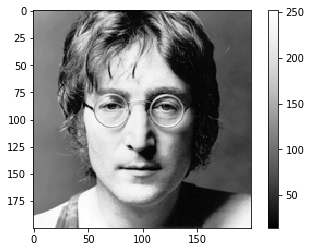

In [5]:
def loadImage(fileName, targetSize=(100,200)):
    """Load and downsample animage"""
    im = Image.open(fileName)
    im.thumbnail(targetSize, Image.ANTIALIAS)
    im = im.convert('L') # 1 for BW dither; L for grayscale; LAB and HSV may be interesting for the future
    return im

img = loadImage('../../photo.jpg' , (200,400))
plt.imshow(img, cmap="Greys_r"); # Reverse, to have black as low (default is to have white as low)
plt.colorbar();

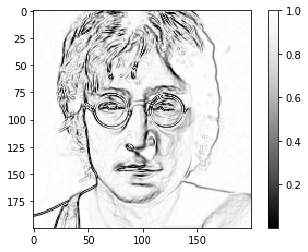

In [6]:
img2 = np.array(img)
kernel1 = np.array([[1, 2, 1], [0,0,0], [-1,-2,-1]]) # Sobel operators
kernel2 = np.array([[1, 0, -1], [2,0,-2], [1,0,-1]])
img_a = signal.convolve2d(img2, kernel1, boundary='symm', mode='same')
img_b = signal.convolve2d(img2, kernel2, boundary='symm', mode='same')
img2 = np.sqrt(np.square(img_a)+np.square(img_b))
img2 = img2 - np.min(img2)
img2 = img2/np.max(img2) # Normalize
img2 = np.abs(img2-0.5)*2 # Both ups and downs are worthy, while 0.5 is evil
#img2 = img2 + img/np.max(img) # Mix with the original
plt.imshow(img2, cmap="Greys_r"); # Reverse, to have black as low (default is to have white as low)
plt.colorbar();

In [7]:
def image_to_data(im):
    y = np.array(im)
    (h,w) = y.shape
    y = np.mean(y.reshape((h*w,1)), axis=1)
    _x,_y = np.meshgrid(np.array(range(w))/w, np.array(range(h))/h)
    x = np.transpose(np.vstack([_x.flatten() , _y.flatten()]))
    x[:,1] = 1-x[:,1] # Images are flipped, so unflip it
    return (x,y)

imgxy, imgz = image_to_data(img2)

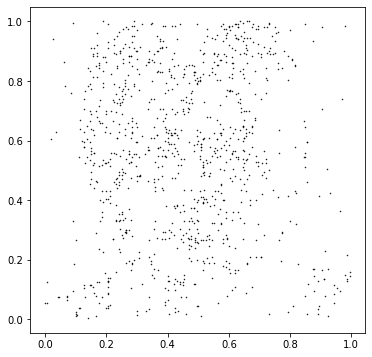

In [8]:
N_POINTS = 1000
np.random.seed(1)

points = sample_points(imgxy, imgz, N_POINTS)
plt.figure(figsize=(6,6))
plt.plot(points[:,0], points[:,1], 'k.', markersize=1);

..........Graph built.
Now making a plot...


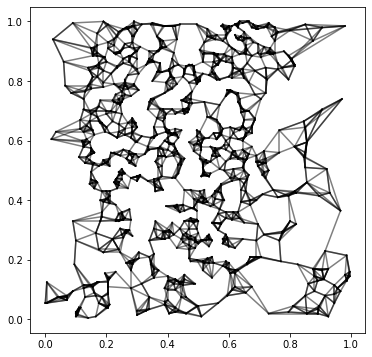

In [9]:
def build_graph(points):
    """Find some reasonably local edges."""
    KEEP_BEST = 5 # How many smallest edges to keep for every point
    n = points.shape[0]
    g = {i:[] for i in range(n)}
    for i in range(n):
        dist = np.sqrt(np.square(points[i,0]-points[:,0])+np.square(points[i,1]-points[:,1]))
        edges = sorted([(dist[j],j) for j in range(n)])[1:(KEEP_BEST+1)] # 1: to skip zero self-edges
        for d,j in edges:
            if j not in g[i]:
                g[i].append((d,j))
            if i not in g[j]:
                g[j].append((d,i))
        if i % 100 == 0: print('.', end='')
    return g

local_graph = build_graph(points)
print('Graph built.')
if True:
    print('Now making a plot...')
    plt.figure(figsize=(6,6))
    for i,val in local_graph.items():
        for _,j in val:
            if i<j: # Let's only draw one half of reciprocal edges
                plt.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], 'k-', alpha=0.5);

..........Done, now drawing :)


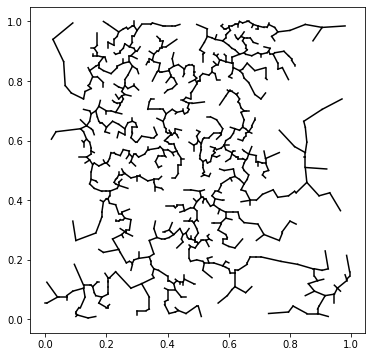

In [10]:
def mst(points, g):
    """Build a minimally spanning tree."""
    g = g.copy()
    nv = points.shape[0]
    visited = [False]*nv
    tree = []
    q = PQ()
    node_count = 0
    
    def visit(i):
        nonlocal visited, q, node_count
        visited[i] = True
        node_count += 1
        if node_count % 100 == 0: print('.', end='')
        for d,j in g[i]:
            q.add(d, (i,j))
    
    visit(0)
    while q.n()>0:
        i,j = q.pop()
        if visited[i] and visited[j]: continue
        if visited[i]: visit(j) 
        else: visit(i)
        tree.append((i,j))
    return tree        

tree = mst(points, local_graph)
print('Done, now drawing :)')
fig = plt.figure(figsize=(6,6));
eplot(points, tree)

Now plotting...


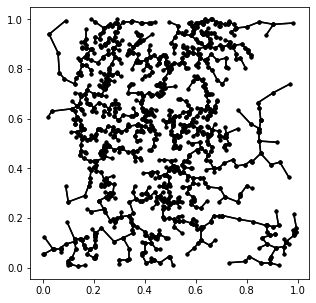

In [11]:
class Graph:
    def __init__(self, gdict=None, xyarray=None):
        if gdict is not None:
            self.gdict = gdict
        else:
            self.gdict = {}
        self.xy = {}
        if xyarray is not None:
            for i,_ in self.gdict.items():
                self.xy[i] = xyarray[i,]
                
    def dist(self,i,j):
        return np.sqrt(np.square(self.xy[i][0]-self.xy[j][0]) + np.square(self.xy[i][1]-self.xy[j][1]))

    def plot(self, show_points=False):
        if show_points: style='k.-'
        else: style='k-'
        for i,val in self.gdict.items():
            for j in val:
                plt.plot([self.xy[i][0], self.xy[j][0]], [self.xy[i][1], self.xy[j][1]], style)
        #plt.xticks([])
        #plt.yticks([])
        
    def splice(self, i,j, newxy=None):
        """Add a point between two existing points."""
        self.gdict[i].remove(j)
        self.gdict[j].remove(i)
        k = max(self.gdict.keys())+1
        self.gdict[k] = [i,j]
        self.gdict[i].append(k)
        self.gdict[j].append(k)
        if newxy is None:
            newxy = (self.xy[i]+self.xy[j])/2
        self.xy[k] = newxy
        return k
    
    def from_edges(self, edges, xy):
        for i in range(xy.shape[0]):
            self.xy[i] = xy[i,]
        for i,j in edges:
            if i not in self.gdict:
                self.gdict[i] = []
            if j not in self.gdict:
                self.gdict[j] = []
            self.gdict[i].append(j)
            self.gdict[j].append(i)
            
    
g_rough = Graph()
g_rough.from_edges(tree, points)
print('Now plotting...')
plt.figure(figsize=(5,5))
g_rough.plot(show_points=True)

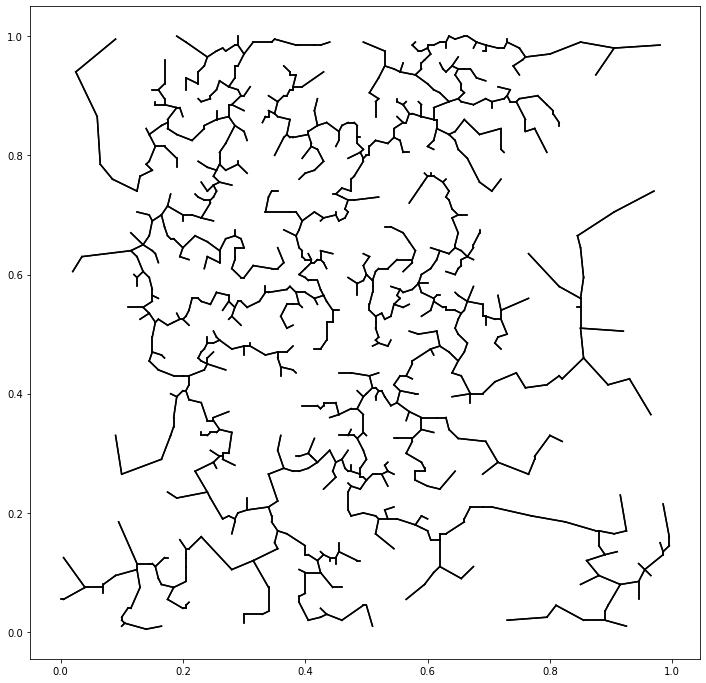

In [12]:
plt.figure(figsize=(12,12))
g_rough.plot()

### Everything below is an attempt to make this plot more ribbony...

### (Doesn't quite work for now)

Now plotting...


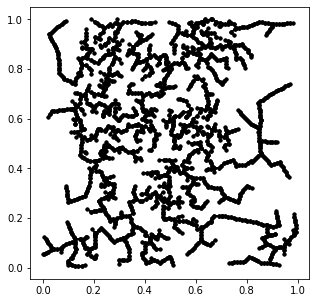

In [13]:
def interpolate(g, min_d=0.01):
    """Intepolate the graph."""
    for i,others in list(g.gdict.items()):
        for j in others:
            d = g.dist(i,j)
            nsteps = int(d/min_d)
            if nsteps>1:
                step = (g.xy[j]-g.xy[i])/nsteps
                edge1 = i
                edge2 = j
                for istep in range(1,nsteps):
                    point = g.xy[i] + step*istep
                    k = g.splice(edge1, edge2, point)
                    edge1 = k
    return g

g = interpolate(g_rough, 0.01)
print('Now plotting...')
plt.figure(figsize=(5,5))
g.plot(show_points=True)

1001 16 0.991251386802524
1010 1008 1.0052978029247157
994 367 1.0055275563469168
892 74 1.0077957199921914
938 389 1.010041759378122
971 477 1.0102156172258159
971 477 1.0103549939762815
971 477 1.0104967987330578
971 477 1.0106465194430694
971 477 1.0108025744034235
971 477 1.010961315998166
971 477 1.0111266303920936
971 477 1.0112948112560536
971 477 1.0114698611952995
971 477 1.0116479613425131
Now plotting...


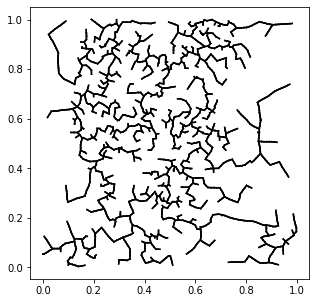

In [14]:
def relax(g, d_min=0.1, nsteps=10):
    """Turn a graph into ribbons."""
    ALPHA = 0.01
    max_force = 0
    for istep in range(nsteps):
        distance = {}
        for i,js in g.gdict.items():            
            for j in js:                
                if i<j: # Spring-like action
                    distance[(i,j)] = g.dist(i, j)
                    distance[(j,i)] = distance[(i,j)]
                    force = (distance[(i,j)] - d_min)*(g.xy[j] - g.xy[i])
                    g.xy[i] += force*ALPHA
                    g.xy[j] += -force*ALPHA
        for i,js in g.gdict.items():            
            for j in js:
                for k in js: # Repulsion
                    if k<j:
                        if (i,j) not in distance: 
                            distance[(i,j)] = g.dist(i, j)
                            distance[(j,i)] = distance[(i,j)]
                        if (i,k) not in distance: 
                            distance[(i,k)] = g.dist(i, k)
                            distance[(k,i)] = distance[(i,k)]
                        va = g.xy[j]-g.xy[i]
                        vb = g.xy[k]-g.xy[i]
                        force = ((1 + np.dot(va,vb)
                                      /max(d_min, distance[(i,j)])/max(d_min, distance[(i,k)]))*
                                 np.sign(va[0]*vb[1]-va[1]*vb[0]))
                        if force>max_force:
                            max_force = force
                            print(j,k,force)
                        g.xy[j] +=  force*ALPHA*np.array([va[1], -va[0]])
                        g.xy[k] += -force*ALPHA*np.array([vb[1], -vb[0]])
    return
                        
relax(g, nsteps=10)
print('Now plotting...')
plt.figure(figsize=(5,5))
g.plot()

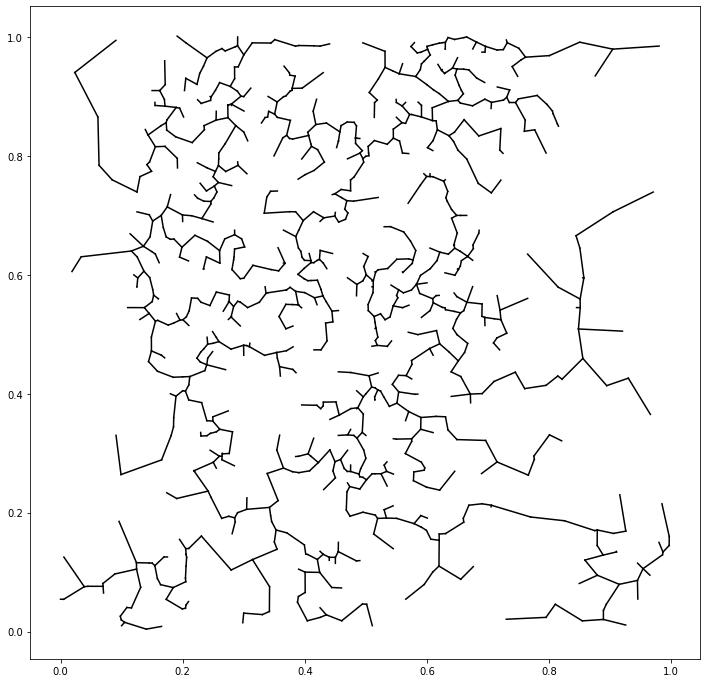

In [15]:
# Same, just larger
fig = plt.figure(figsize=(12,12));
eplot(points, tree)